# Finding the Best Chocolate Bars

![chocolate.jpg](images/chocolate.jpg)

## Competition Brief

📖 **Background**
You work at a specialty foods import company that wants to expand into gourmet chocolate bars. Your boss needs your team to research this market to inform your initial approach to potential suppliers.

After finding valuable chocolate bar ratings online, you need to explore if the chocolate bars with the highest ratings share any characteristics that could help you narrow your search for suppliers (e.g., cacao percentage, bean country of origin, etc.)

💾 **The data**

Your team created a file with the following information ([source](https://flavorsofcacao.com)):
- "id" - id number of the review
- "manufacturer" - Name of the bar manufacturer
- "company_location" - Location of the manufacturer
- "year_reviewed" - From 2006 to 2021
- "bean_origin" - Country of origin of the cacao beans
- "bar_name" - Name of the chocolate bar
- "cocoa_percent" - Cocoa content of the bar (%)
- "num_ingredients" - Number of ingredients
- "ingredients" - B (Beans), S (Sugar), S* (Sweetener other than sugar or beet sugar), C (Cocoa Butter), (V) Vanilla, (L) Lecithin, (Sa) Salt
- "review" - Summary of most memorable characteristics of the chocolate bar
- "rating" - 1.0-1.9 Unpleasant, 2.0-2.9 Disappointing, 3.0-3.49 Recommended, 3.5-3.9 Highly Recommended, 4.0-5.0 Oustanding

***Acknowledgments**: Brady Brelinski, Manhattan Chocolate Society*

💪 **Challenge**
Create a report to summarize your research. Include:

1. What is the average rating by country of origin?
2. How many bars were reviewed for each of those countries?
3. Create plots to visualize findings for questions 1 and 2.
4. Is the cacao bean's origin an indicator of quality? 
5. [Optional] How does cocoa content relate to rating? What is the average cocoa content for bars with higher ratings (above 3.5)?
6. [Optional 2] Your research indicates that some consumers want to avoid bars with lecithin. Compare the average rating of bars with and without lecithin (L in the ingredients).
7. Summarize your findings.

⌛️ **Time is ticking. Good luck!**

## Preliminaries

In [113]:
# importing relevant libraries
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scipy_stats
import seaborn as sns
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.formula.api import ols
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

In [2]:
# read in the data
df = pd.read_csv('data/chocolate_bars.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2530 non-null   int64  
 1   manufacturer      2530 non-null   object 
 2   company_location  2530 non-null   object 
 3   year_reviewed     2530 non-null   int64  
 4   bean_origin       2530 non-null   object 
 5   bar_name          2530 non-null   object 
 6   cocoa_percent     2530 non-null   float64
 7   num_ingredients   2443 non-null   float64
 8   ingredients       2443 non-null   object 
 9   review            2530 non-null   object 
 10  rating            2530 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 217.5+ KB


In [3]:
# take a look at the first datapoints
df.head()

,id,manufacturer,company_location,year_reviewed,bean_origin,bar_name,cocoa_percent,num_ingredients,ingredients,review,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3.0,"B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,3.0,"B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,3.0,"B,S,C","cocoa, blackberry, full body",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68.0,3.0,"B,S,C","chewy, off, rubbery",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72.0,3.0,"B,S,C","fatty, earthy, moss, nutty,chalky",3.00


In [4]:
# and the last couple
df.tail()

,id,manufacturer,company_location,year_reviewed,bean_origin,bar_name,cocoa_percent,num_ingredients,ingredients,review,rating
2525,1205,Zotter,Austria,2014,Blend,Raw,80.0,4.0,"B,S*,C,Sa","waxy, cloying, vegetal",2.75
2526,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,3.0,"B,S,C","strong nutty, marshmallow",3.75
2527,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75.0,3.0,"B,S,C","fatty, earthy, cocoa",3.00
2528,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,3.0,"B,S,C","fatty, mild nuts, mild fruit",3.25
2529,2170,Zotter,Austria,2018,Belize,Maya Mtn,72.0,3.0,"B,S,C","muted, roasty, accessible",3.50


## Average Ratings and Country Counts

In [5]:
avg_rating_by_country = df.groupby('bean_origin')[['rating']].mean().sort_values(by = 'rating', ascending = True)
avg_rating_by_country[['count']] = df.groupby('bean_origin')['id'].count()

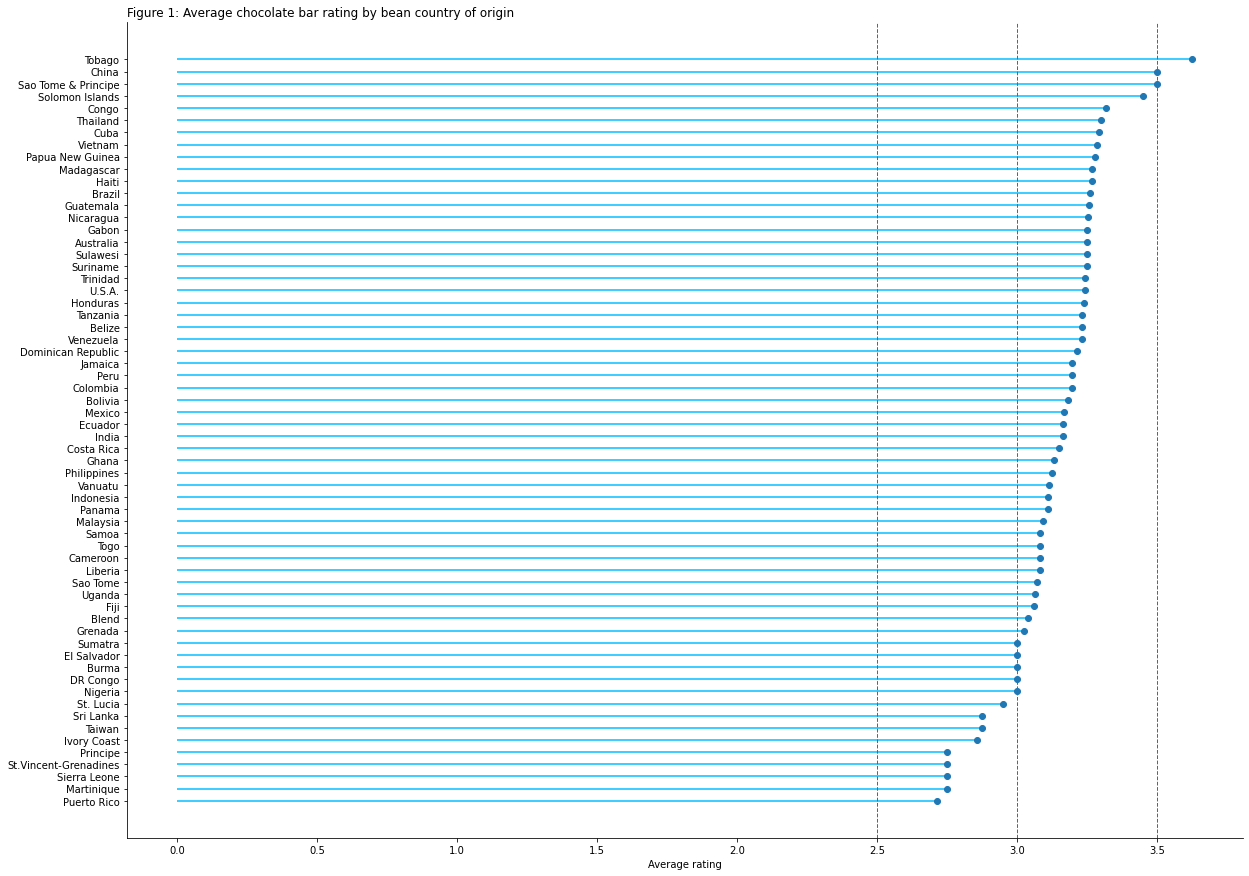

In [6]:
# plot the ratings
fig = plt.figure(figsize = (20, 15))
plot_range = range(1, len(avg_rating_by_country.index) + 1)
plt.hlines(y = plot_range, xmin = 0, xmax = avg_rating_by_country['rating'], color = 'deepskyblue')
plt.plot(avg_rating_by_country['rating'], plot_range, "o")
plt.axvline(x = 2.5, linewidth = 1, linestyle = '--')
plt.axvline(x = 3.0, linewidth = 1, linestyle = '--')
plt.axvline(x = 3.5, linewidth = 1, linestyle = '--')

plt.yticks(plot_range, avg_rating_by_country.index)
plt.title("Figure 1: Average chocolate bar rating by bean country of origin", loc = 'left')
plt.xlabel('Average rating')
sns.despine()

All countries had an average rating of between 2.5 (disappointing) and 4 (highly recommended) out of five, which meant that no chocolate bar was labelled unpleasant or outstanding. Tobago had the highest average rating at 3.6, and Puerto Rico the lowest at 2.7. In addition, most countries had an average rating of 3.0 or above (recommended); only nine out of the 62 countries in the dataset (14.5%) had an averag rating of less than 3.0.

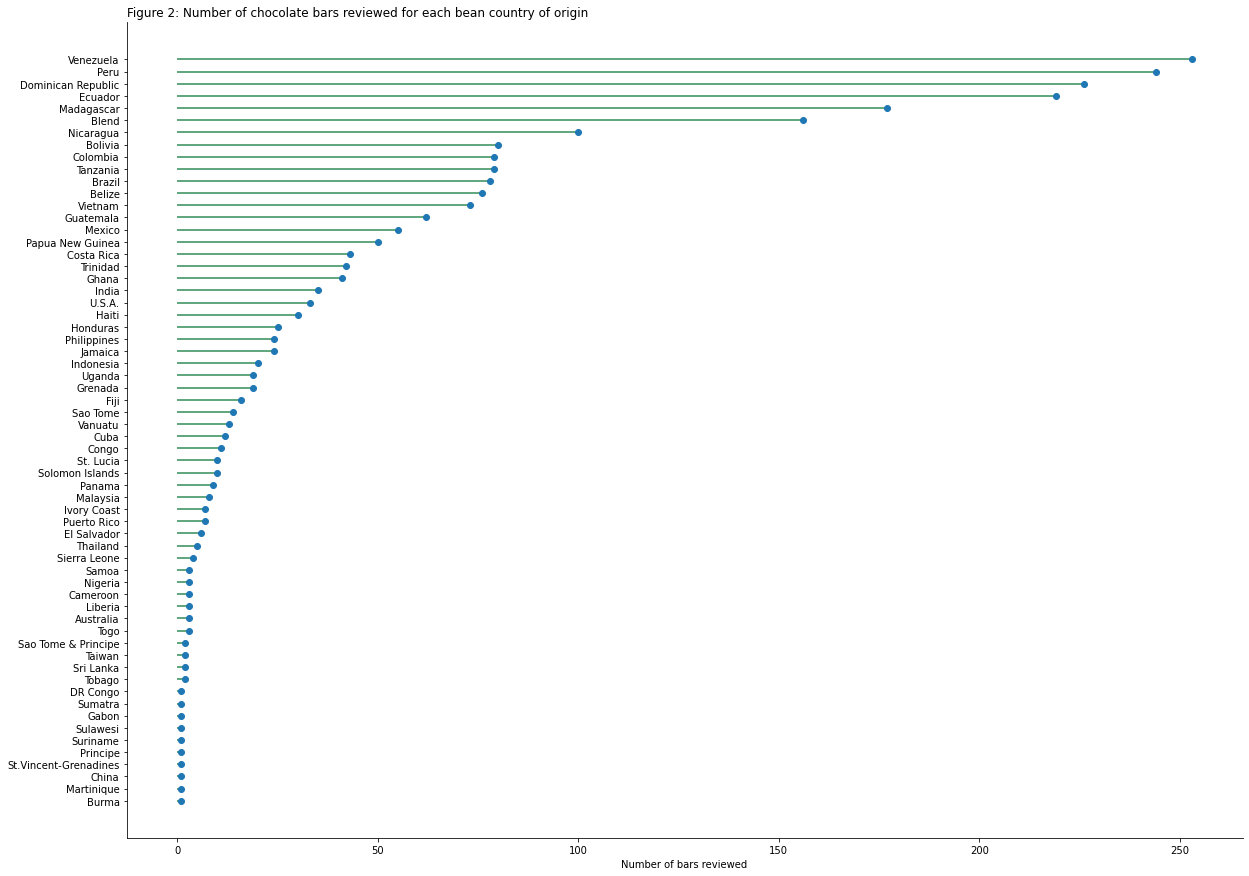

In [7]:
# resort the dataframe by country counts
avg_rating_by_country = avg_rating_by_country.sort_values(by = 'count', ascending = True)

# plot the country counts
fig = plt.figure(figsize = (20, 15))
plot_range = range(1, len(avg_rating_by_country.index) + 1)
plt.hlines(y = plot_range, xmin = 0, xmax = avg_rating_by_country['count'], color = 'seagreen')
plt.plot(avg_rating_by_country['count'], plot_range, "o")

plt.yticks(plot_range, avg_rating_by_country.index)
plt.title("Figure 2: Number of chocolate bars reviewed for each bean country of origin", loc = 'left')
plt.xlabel('Number of bars reviewed')
sns.despine()

Under 100 chocolate bars were reviewed for most (88.8%) countries. At the other end of the scale, there were ten countries for which only a single bar was reviewed and 29 for which ten or less were reviewed.

## The Relationship Between Country of Origin and Bar Quality

For this next section in which whether the cacao's bean's origin is an indicator of quality is investigated, quality is defined as the rating received by the bar.

In [8]:
# encode bean_origin as a set of numeric value
enc = OrdinalEncoder()
df[['bean_origin_enc']] = enc.fit_transform(df[['bean_origin']])

# calculate Pearson's R correlation coefficient
corr, _ = scipy_stats.pearsonr(df.bean_origin_enc, df.rating)
print('Pearson R correlation: %.5f' % corr)

# calculate Spearman's rho correlation coefficient
corr, _ = scipy_stats.spearmanr(df.bean_origin_enc, df.rating)
print('Spearman rho correlation: %.5f' % corr)

# calculate Kendall's Tau correlation coefficient
corr, _ = scipy_stats.kendalltau(df.bean_origin_enc, df.rating)
print('Kendall Rank correlation: %.5f' % corr)

Pearson R correlation: 0.04845
Spearman rho correlation: 0.03263
Kendall Rank correlation: 0.02420


Each of the three measures indicate that there's only a very weak to non-existant relationship between bean origin and quality. However, from experience, these statistics can be misleading.

In [9]:
# sort the chocolate bars by median rating
sorted_index = df.groupby('bean_origin').mean('rating').sort_values(by = 'rating', ascending = False).index
df_order = pd.CategoricalDtype(sorted_index, ordered = True)
df['bean_origin'] = df['bean_origin'].astype(df_order)
sorted_df = df.sort_values(by = 'bean_origin')

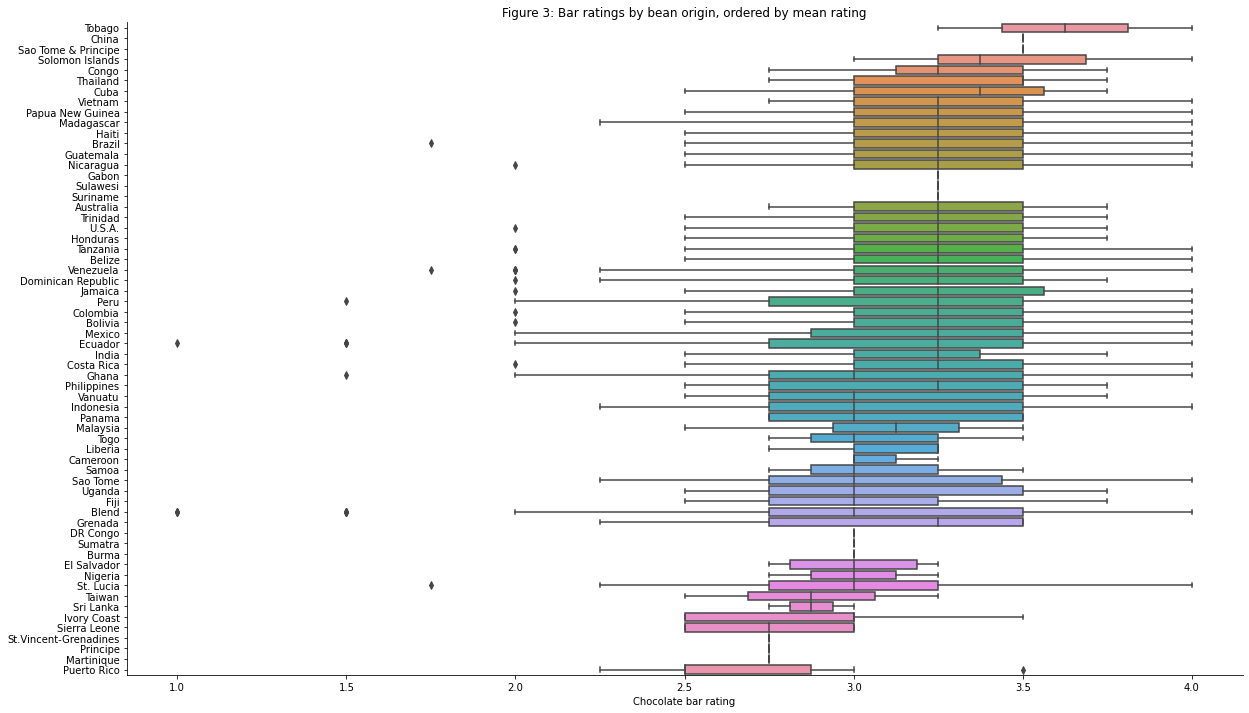

In [10]:
# boxplots
fig = plt.figure(figsize = (20, 12))
sns.boxplot(x = "rating", y = "bean_origin", data = sorted_df)
plt.xlabel("Chocolate bar rating")
plt.ylabel("")
plt.title("Figure 3: Bar ratings by bean origin, ordered by mean rating")
sns.despine();

The plot indicates that bean origin could be some indication of average quality as there appears to be several groupings of countries based on their ratings. For example, the top group could be made up of Tobago, Sao Tome and Principe, Thailand, China, Cuba and the Soloman Islands, and the bottom group made up of Puerto Rico, St. Vincent-Grenadines, Martinique and Principe. That being said, some countries have only a single or handful of ratings, whereas some countries have several hundred, which could distort the results somewhat (or even result in a biased conclusion).

The ANOVA and Kruskal Wallis H test are the parametric and non-parametric versions of test for whether or not the population means for two or more groups are equal. The ANOVA one-way test makes three assumptions: samples are normally distributed, sample variances are the same, and the samples are independent. As is shown below, the first two assumptions are violated 

In [11]:
# anova test
anova_mod = ols('rating ~ C(bean_origin)', data = df).fit()
result_anova = sm.stats.anova_lm(anova_mod, typ = 2)

ShapiroResult(statistic=0.9776220321655273, pvalue=1.646309397324676e-19)


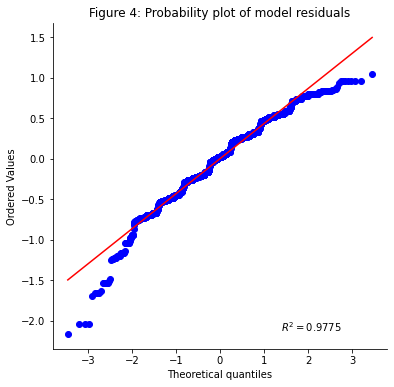

In [12]:
# test assumption: normality of population distributions
print(scipy_stats.shapiro(anova_mod.resid))

fig = plt.figure(figsize = (6, 6))
normality_plot, stat = scipy_stats.probplot(anova_mod.resid, plot= plt, rvalue= True)
plt.title("Figure 4: Probability plot of model residuals")
sns.despine();

In [13]:
# test assumption: equal sample variances
desc_stats = df.groupby('bean_origin')['rating'].describe().sort_values(by = 'std')
min_std = desc_stats['std'][1] # smallest is zero
max_std = desc_stats['std'].max()

print(max_std / min_std)

4.417650139422817


The largest variance is 0.63 and the second smallest is 0.14 (the smallest is 0), so the largest is over 4 times the size of the smallest. This is sufficient evidence to conclude that the assumption of homogenous sample variances is violated.

In [14]:
# anova test
# print(result_anova)

# alternative formulation
# print(scipy_stats.f_oneway(*(df.loc[df['bean_origin'] == group, 'rating'] for group in df['bean_origin'].unique())))

In [15]:
scipy_stats.kruskal(*(df.loc[df['bean_origin'] == group, 'rating'] for group in df['bean_origin'].unique()))

KruskalResult(statistic=74.90080734628437, pvalue=0.10874186831887003)

In [16]:
# count the number of ratings by bean origin
all_rating_counts = df.groupby('bean_origin').count()[['rating']].reset_index(drop = False)
all_rating_counts.columns = ['bean_origin', 'count']
rating_counts = all_rating_counts[all_rating_counts['count'] >= 5]

# retain only those countries with ratings greater or equal to five
countries_list = list(rating_counts.bean_origin)
countries_df = df[df['bean_origin'].isin(countries_list)]

# re-run the Kruskal Wallis test
scipy_stats.kruskal(*(countries_df.loc[countries_df['bean_origin'] == group, 'rating'] for group in countries_df['bean_origin'].unique()))

KruskalResult(statistic=55.66615475946004, pvalue=0.050860840597506424)

The Kruskal-Wallis H-test for independent samples tests the null hypothesis that the population mean of all groups are equal. However, note that a typical rule of thumb is that the number of samples in each group must have at least five measurements due to the assumption that H has a chi-squared distribution. Whilst use of all the data failed to reject the null hypothesis, which meant that there was insufficient evidence to conclude that there was a significant difference between the mean chocolate bar rating by bean origin, the reduced dataset just rejected it at the same significance level.

## The Relationship Between Cocoa Content and Rating

In [17]:
# calculate Pearson's R correlation coefficient
corr, _ = scipy_stats.pearsonr(df.cocoa_percent, df.rating)
print('Pearson R correlation: %.5f' % corr)

# calculate Spearman's rho correlation coefficient
corr, _ = scipy_stats.spearmanr(df.cocoa_percent, df.rating)
print('Spearman rho correlation: %.5f' % corr)

# calculate Kendall's Tau correlation coefficient
corr, _ = scipy_stats.kendalltau(df.cocoa_percent, df.rating)
print('Kendall Rank correlation: %.5f' % corr)

Pearson R correlation: -0.14669
Spearman rho correlation: -0.10986
Kendall Rank correlation: -0.08553


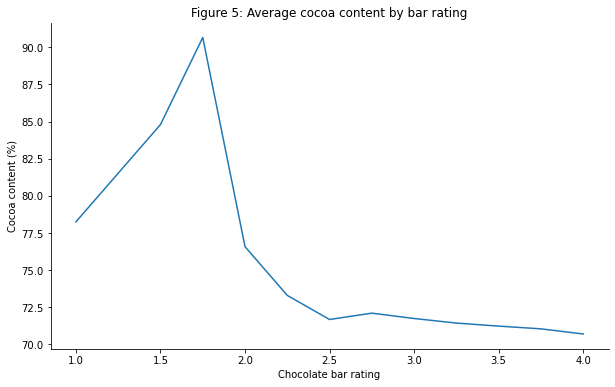

In [18]:
cocoa_content_by_rating = df.copy()
cocoa_content_by_rating['rating>3.5'] = cocoa_content_by_rating.apply(lambda x: "yes" if x.rating > 3.5 else "no", axis = 1)
cocoa_content_by_rating['rating>2.25'] = cocoa_content_by_rating.apply(lambda x: "yes" if x.rating > 2.25 else "no", axis = 1)

cocoa_content_summary = cocoa_content_by_rating.groupby('rating')['cocoa_percent'].mean().reset_index()

fig = plt.figure(figsize = (10, 6))
sns.lineplot(data = cocoa_content_summary, x = "rating", y = "cocoa_percent")
plt.xlabel("Chocolate bar rating")
plt.ylabel("Cocoa content (%)")
plt.title("Figure 5: Average cocoa content by bar rating")
sns.despine();

In [19]:
cocoa_content_by_rating.groupby('rating>2.25')['cocoa_percent'].mean().reset_index()

,rating>2.25,cocoa_percent
0,no,77.701493
1,yes,71.474827


All three correlation metrics indicate a weakly negative relationship between the amount of cocoa present in a chocolate bar and its average rating, which is consistent with the figure showing the average cocoa content for each rating present in the dataset. The average cocoa content for bars with ratings higher than 3.5 is 70.9%, compared to an average of 71.8% for bars with a rating of 3.5 or lower. However, as is clearly indicated in the plot, the breakpoint with respect to cocoa content is actually around 2 to 2.25. That is, chocolate bars with ratings lower or equal to that boundary have an average cocoa content of 77.7%, compared to 71.5% for bars with higher ratings.

ShapiroResult(statistic=0.9732174277305603, pvalue=2.2688754389278685e-21)


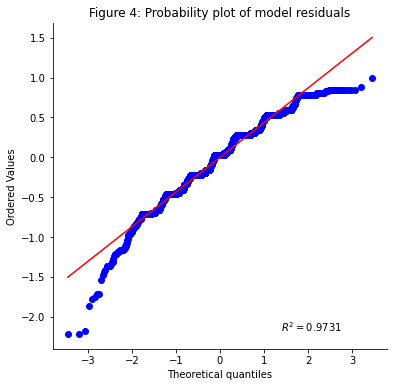

In [20]:
# anova test
anova_mod = ols('rating ~ cocoa_percent', data = df).fit()
result_anova = sm.stats.anova_lm(anova_mod, typ = 2)

# test assumption: normality of population distributions
print(scipy_stats.shapiro(anova_mod.resid))

fig = plt.figure(figsize = (6, 6))
normality_plot, stat = scipy_stats.probplot(anova_mod.resid, plot= plt, rvalue= True)
plt.title("Figure 4: Probability plot of model residuals")
sns.despine();

In [21]:
# test assumption: equal sample variances
desc_stats = df.groupby('cocoa_percent')['rating'].describe().sort_values(by = 'std')
min_std = desc_stats['std'].reset_index()['std'][1]
max_std = desc_stats['std'].max()

print(max_std / min_std)

5.0


In [22]:
scipy_stats.kruskal(*(df.loc[df['cocoa_percent'] == group, 'rating'] for group in df['cocoa_percent'].unique()))

KruskalResult(statistic=181.07409685145984, pvalue=3.095970078699227e-18)

In [23]:
# count the number of ratings by cocoa content
all_rating_counts = df.groupby('cocoa_percent').count()[['rating']].reset_index(drop = False)
all_rating_counts.columns = ['cocoa_percent', 'count']
rating_counts = all_rating_counts[all_rating_counts['count'] >= 5]

# retain only those values with ratings greater or equal to five
content_list = list(rating_counts.cocoa_percent)
content_df = df[df['cocoa_percent'].isin(content_list)]

# re-run the Kruskal Wallis test
scipy_stats.kruskal(*(content_df.loc[content_df['cocoa_percent'] == group, 'rating'] for group in content_df['cocoa_percent'].unique()))

KruskalResult(statistic=152.99234600078697, pvalue=3.5539722326107876e-19)

What the results of the Kruskal-Wallis H-test is essentially saying is that there is at least one pair of ratings for which the difference in cocoa content is significantly different. Additional tests would be required to identify those pairings, but this is out of the current scope.

In [24]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

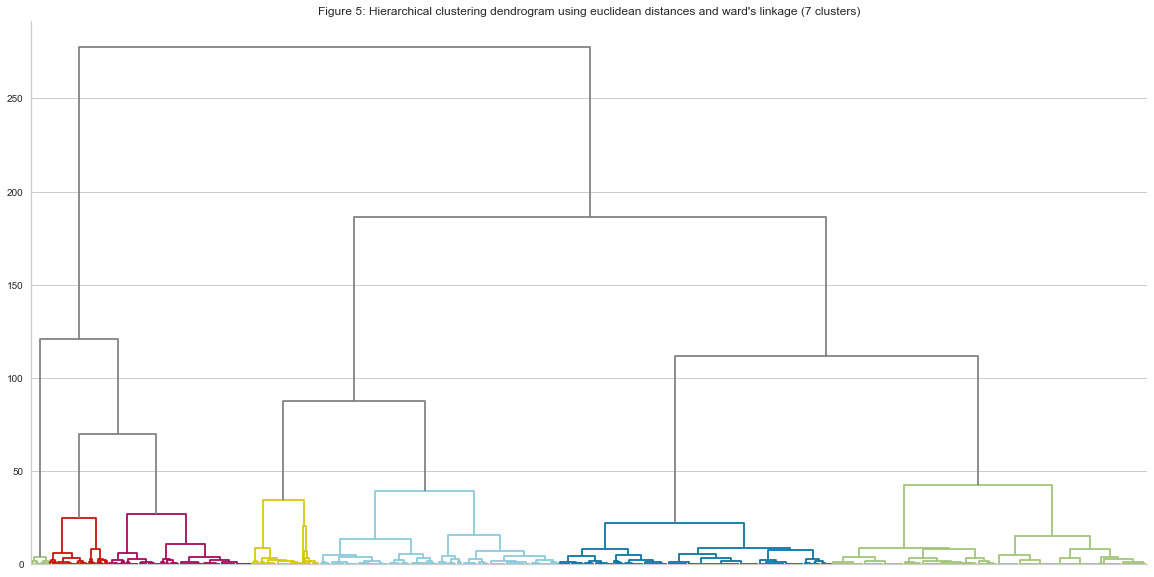

In [85]:
cluster_df = df.loc[:, ['rating', 'cocoa_percent']]

agg_model = AgglomerativeClustering(compute_full_tree = True, compute_distances = True).fit(cluster_df)

fig = plt.figure(figsize = (20, 10))
plot_dendrogram(agg_model, truncate_mode = "level", above_threshold_color = 'grey', color_threshold = 50, no_labels = True)
plt.title("Figure 5: Hierarchical clustering dendrogram using euclidean distances and ward's linkage (7 clusters)")
sns.despine()

The dendrogram indicates that anything up to seven clusters could be considered appropriate, although one cluster is very tiny, which is not ideal.

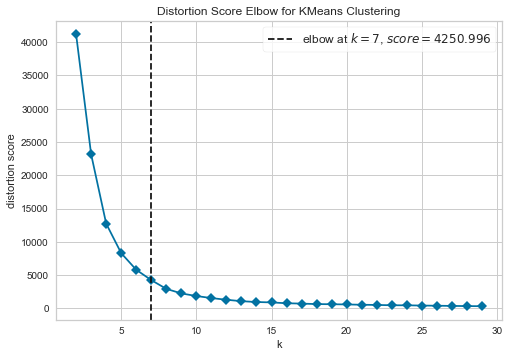

In [109]:
kmeans_model = KMeans()
visualiser = KElbowVisualizer(kmeans_model, k = (2,30), timings = False)
visualiser.fit(cluster_df)
visualiser.show();

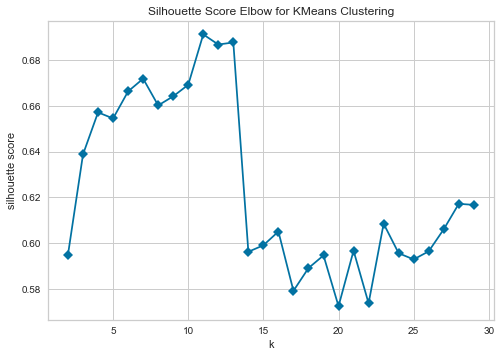

In [111]:
visualiser = KElbowVisualizer(kmeans_model, k = (2,30), metric ='silhouette', locate_elbow = False, timings = False)
visualiser.fit(cluster_df)
visualiser.show();

Elbow plots and silhoette scores are two of the most common methods for determining the optimal number of clusters. Unfortunately they disagree in this case. The elbow method suggests 7 clusters, where the silhouette score method suggests 11 clusters.

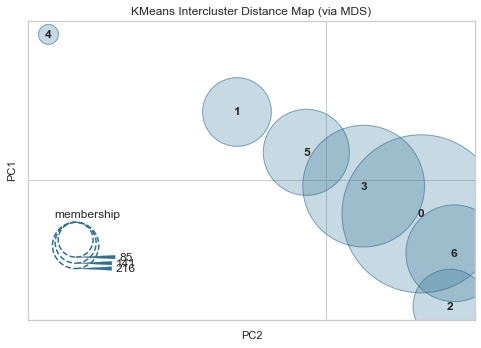

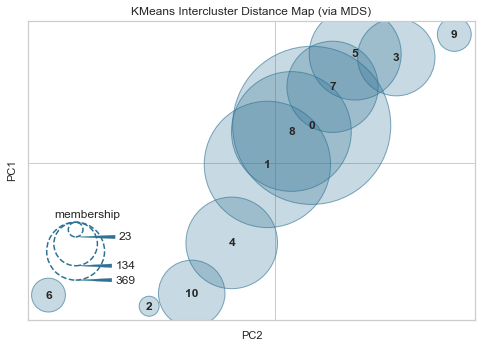

In [119]:
kmeans4 = KMeans(n_clusters = 4)
kmeans7 = KMeans(n_clusters = 7)
kmeans11 = KMeans(n_clusters = 11)

visualizer = InterclusterDistance(kmeans7)
visualizer.fit(cluster_df)
visualizer.show();

visualizer = InterclusterDistance(kmeans11)
visualizer.fit(cluster_df)
visualizer.show();

Unfortunately, with either option there seems to be a lot of overlap, indicating that the clusters are very similar in their characteristics.

## Lecithin

Your research indicates that some consumers want to avoid bars with lecithin. Compare the average rating of bars with and without lecithin (L in the ingredients)

In [149]:
# create a copy of the dataframe and identify which chocolate bars contain lecithin
lecithin_df = df.copy()
lecithin_df['contains_lecithin'] = np.where(lecithin_df.ingredients.str.contains("L"), "yes", "no")

# count the numbers with and without lecithin
lecithin_df.groupby('contains_lecithin')['id'].count()

contains_lecithin
no     3.225128
yes    3.099569
Name: rating, dtype: float64

In [150]:
# calculate the average rating
lecithin_df.groupby('contains_lecithin')['rating'].mean()

contains_lecithin
no     3.225128
yes    3.099569
Name: rating, dtype: float64

In [151]:
# calculate the average rating
lecithin_df.groupby('contains_lecithin')['cocoa_percent'].mean()

contains_lecithin
no     71.883590
yes    70.819828
Name: cocoa_percent, dtype: float64

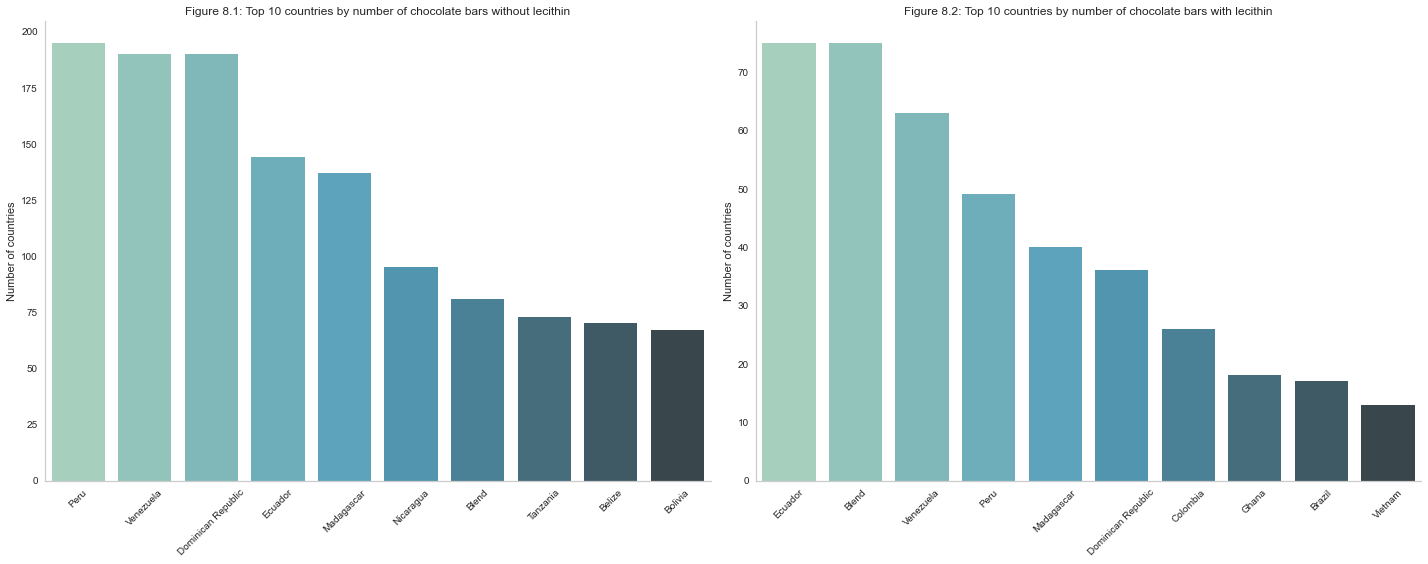

In [243]:
yes_data = lecithin_df.loc[lecithin_df.contains_lecithin == "yes"]
no_data = lecithin_df.loc[lecithin_df.contains_lecithin == "no"]

fig, axs = plt.subplots(ncols = 2, figsize = (20, 8))
ax = sns.countplot(x = "bean_origin", data = no_data, palette="GnBu_d", order = no_data['bean_origin'].value_counts().index[:10], ax = axs[0])
ax.grid(False)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel("")
ax.set_ylabel("Number of countries")
ax.set_title("Figure 8.1: Top 10 countries by number of chocolate bars without lecithin")

ax = sns.countplot(x = "bean_origin", data = yes_data, palette="GnBu_d", order = yes_data['bean_origin'].value_counts().index[:10], ax = axs[1])
ax.grid(False)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel("")
ax.set_ylabel("Number of countries")
ax.set_title("Figure 8.2: Top 10 countries by number of chocolate bars with lecithin")

fig.tight_layout()
sns.despine();

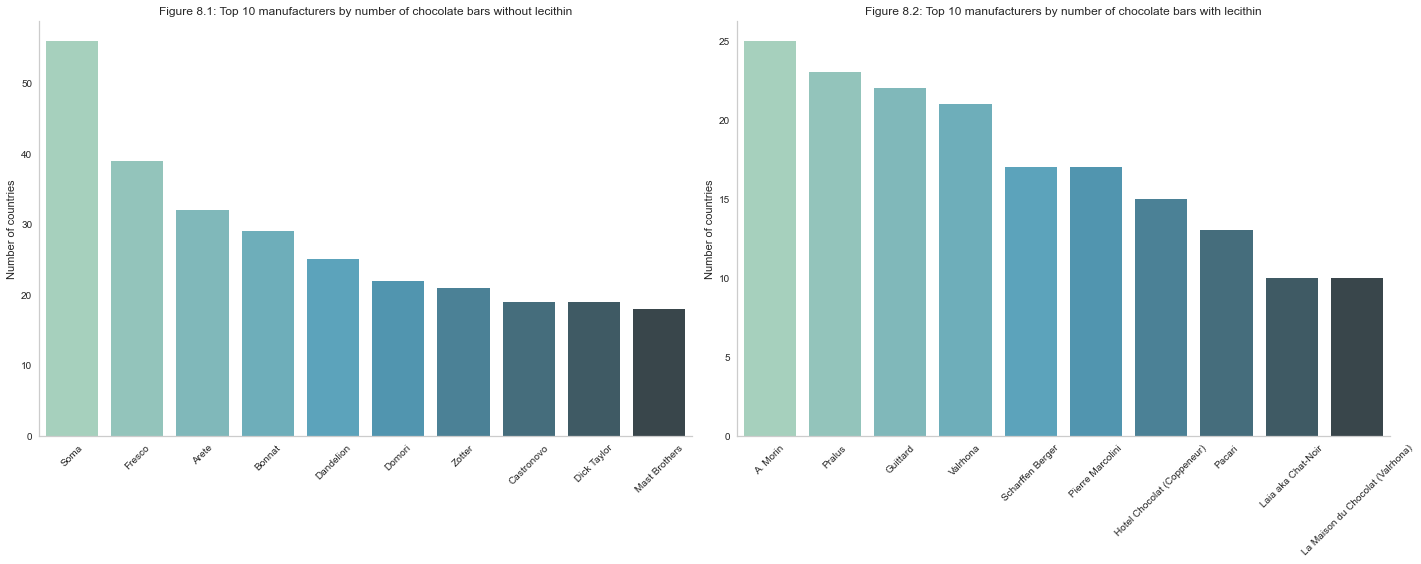

In [251]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 8))
ax = sns.countplot(x = "manufacturer", data = no_data, palette="GnBu_d", order = no_data['manufacturer'].value_counts().index[:10], ax = axs[0])
ax.grid(False)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel("")
ax.set_ylabel("Number of countries")
ax.set_title("Figure 8.1: Top 10 manufacturers by number of chocolate bars without lecithin")

ax = sns.countplot(x = "manufacturer", data = yes_data, palette="GnBu_d", order = yes_data['manufacturer'].value_counts().index[:10], ax = axs[1])
ax.grid(False)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_xlabel("")
ax.set_ylabel("Number of countries")
ax.set_title("Figure 8.2: Top 10 manufacturers by number of chocolate bars with lecithin")

fig.tight_layout()
sns.despine();

- Most chocolate bars (77.1%) do not contain lecithin, but the average rating is slightly higher for the ones that do (3.2 vs 3.1).
- There is also very little difference in the average cocoa content for bars (71.9% vs 70.8%).
- The top three bean country of origins are Peru, Venezuela and the Dominican Republic. However, there is a fair bit of overlap as one of the top three countries by bean origin containing the ingredient lecithin is also Venezuela.
- The top three manufacturers of bars without lecithin were Soma, Fresco and Arete, compared to A. Morin, Pralus and Guittard for chocolate bars containing lecithin.
- Unfortunately, a similar analysis by chocolate bar name revealed no useful information as it appeared that in many cases, names of countries had been substituted.